# Transfer Learning & Fine Tuning
# Dataset: VGGFace2
# Model: Resnet50

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread
import os

from keras.models import Sequential, Model#, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Input, AveragePooling2D, Lambda
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.backend import l2_normalize, clear_session

#from keras import backend as K

import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## 1. Create dataframe containing images and gender labels

In [2]:
# load meta data file containing names, gender and train/test flag
meta_df = pd.read_csv('/home/11332722/final_project/data/vggface2/identity_meta.csv', 
                      quotechar='"',skipinitialspace=True)

In [3]:
meta_df.head(5)

,Class_ID,Name,Sample_Num,Flag,Gender
0,n000001,14th_Dalai_Lama,424,0,m
1,n000002,A_Fine_Frenzy,315,1,f
2,n000003,A._A._Gill,205,1,m
3,n000004,A._J._Buckley,387,1,m
4,n000005,A._J._Pierzynski,229,1,m


In [4]:
# dictionary to replace gender m with 0, and f with 1
gender = {'m': 0,'f': 1} 

In [5]:
meta_df['Gender_Num'] = [gender[item] for item in meta_df.Gender] 

In [6]:
meta_df.head(5)

,Class_ID,Name,Sample_Num,Flag,Gender,Gender_Num
0,n000001,14th_Dalai_Lama,424,0,m,0
1,n000002,A_Fine_Frenzy,315,1,f,1
2,n000003,A._A._Gill,205,1,m,0
3,n000004,A._J._Buckley,387,1,m,0
4,n000005,A._J._Pierzynski,229,1,m,0


In [7]:
# create dataframe from test image files
import os                                                                                                             

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

lst_files = list_files('/home/11332722/final_project/data/vggface2/test/')

test_files_df = pd.DataFrame(lst_files)
test_files_df.columns = ['Path']
test_files_df.head()

,Path
0,/home/11332722/final_project/data/vggface2/tes...
1,/home/11332722/final_project/data/vggface2/tes...
2,/home/11332722/final_project/data/vggface2/tes...
3,/home/11332722/final_project/data/vggface2/tes...
4,/home/11332722/final_project/data/vggface2/tes...


In [8]:
# check single row to make sure value is as expected
test_files_df['Path'][2]

'/home/11332722/final_project/data/vggface2/test/n006211/0213_01.jpg'

In [9]:
# add columns to test_files_df
new = test_files_df["Path"].str.split("/", n = 8, expand = True)


In [10]:
new

,0,1,2,3,4,5,6,7,8
0,,home,11332722,final_project,data,vggface2,test,n006211,0089_01.jpg
1,,home,11332722,final_project,data,vggface2,test,n006211,0168_01.jpg
2,,home,11332722,final_project,data,vggface2,test,n006211,0213_01.jpg
3,,home,11332722,final_project,data,vggface2,test,n006211,0010_01.jpg
4,,home,11332722,final_project,data,vggface2,test,n006211,0115_01.jpg
5,,home,11332722,final_project,data,vggface2,test,n006211,0470_01.jpg
6,,home,11332722,final_project,data,vggface2,test,n006211,0511_02.jpg
7,,home,11332722,final_project,data,vggface2,test,n006211,0032_01.jpg
8,,home,11332722,final_project,data,vggface2,test,n006211,0502_01.jpg
9,,home,11332722,final_project,data,vggface2,test,n006211,0201_01.jpg


In [11]:
# add File_Name to test_files_df
test_files_df["File_Name"]= new[8] 
  
# add Class_ID to test_files_df
test_files_df["Class_ID"]= new[7] 

In [12]:
#check df
test_files_df.head()

,Path,File_Name,Class_ID
0,/home/11332722/final_project/data/vggface2/tes...,0089_01.jpg,n006211
1,/home/11332722/final_project/data/vggface2/tes...,0168_01.jpg,n006211
2,/home/11332722/final_project/data/vggface2/tes...,0213_01.jpg,n006211
3,/home/11332722/final_project/data/vggface2/tes...,0010_01.jpg,n006211
4,/home/11332722/final_project/data/vggface2/tes...,0115_01.jpg,n006211


In [13]:
# merge test_files_df with  meta_df
test_files_df = test_files_df.merge(meta_df,how='inner',on='Class_ID')

In [14]:
test_files_df.head()

,Path,File_Name,Class_ID,Name,Sample_Num,Flag,Gender,Gender_Num
0,/home/11332722/final_project/data/vggface2/tes...,0089_01.jpg,n006211,Mohammad_Ali,249,0,m,0
1,/home/11332722/final_project/data/vggface2/tes...,0168_01.jpg,n006211,Mohammad_Ali,249,0,m,0
2,/home/11332722/final_project/data/vggface2/tes...,0213_01.jpg,n006211,Mohammad_Ali,249,0,m,0
3,/home/11332722/final_project/data/vggface2/tes...,0010_01.jpg,n006211,Mohammad_Ali,249,0,m,0
4,/home/11332722/final_project/data/vggface2/tes...,0115_01.jpg,n006211,Mohammad_Ali,249,0,m,0


1) import code provided by VGGFace2 team @ https://drive.google.com/file/d/1AHVpuB24lKAqNyRRjhX7ABlEor6ByZlS/view
2) 


## 2. Create train and test datasets

In [15]:
# Create train and test sets 

test_files_df = test_files_df.sample(n=5000)

train_df , test_df = train_test_split(test_files_df, test_size = 0.2, shuffle = True , random_state = 44,
                                              stratify = test_files_df['Gender_Num']) # trmobr if problems

In [16]:
# Reset df indexes because the flow_from_dataframe expects a 0 index
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

## 3. Import ResNet50 model trained on VGGFace2 (from WeidiXie gihub)

In [17]:
# import code provided by VGGFace2 team @ https://drive.google.com/file/d/1AHVpuB24lKAqNyRRjhX7ABlEor6ByZlS/view
# this link came from https://github.com/WeidiXie/Keras-VGGFace2-ResNet50 (in the Model section)
os.chdir(r"/jupyteruser/11332722/vggface2_Keras/tool/")
import toolkits

os.chdir(r"/jupyteruser/11332722/vggface2_Keras/src/")
import config
import resnet
import utils
import model # commented out import new_layers

In [18]:
# commented out toolkits.initialize_GPU(args) but still didn't work
#%run "/jupyteruser/11332722/vggface2_Keras/src/predict.py"

In [19]:
#clear_session()
original_model = model.Vggface2_ResNet50(mode='train')

In [20]:
original_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [21]:
# load pre-trained weights
weights_file = '/home/11332722/vggface2_Keras/model/resnet50_softmax_dim512/weights.h5'
original_model.load_weights(weights_file, by_name=False) # by_name = True for fine tuning or transfer learning (if model = 'eval')

## 3. Modify model via Feature Extraction and Fine Tuning 
A few useful references:<br/>

**Replacing layers**<br/>

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751<br/>

https://www.tensorflow.org/alpha/tutorials/images/transfer_learning<br/>
* collab notebook at: 
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/images/transfer_learning.ipynb<br/>

https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/<br/>

https://github.com/tensorflow/tensorflow/issues/22479<br/>

**Similar project**<br/>

http://gigantes.ii.uam.es/fierrez/files/2018_CIARP_BiasFace_Acien.pdf

### 3.1 Feature Extraction (i.e. freeze convolutional base and add a new classification head)

In [22]:
# create new base model (includes all original layers up to classification)
layer_name = 'activation_49'
conv_base_model= Model(inputs=original_model.input, 
                       outputs=original_model.get_layer(layer_name).output,
                       name = 'conv_base_model')

In [23]:
conv_base_model.trainable = False

In [24]:
#conv_base_model.summary()

In [25]:
# check last layer of conv_base_model
conv_base_model.layers[-1].output.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(2048)])

In [26]:
global_average_layer = GlobalAveragePooling2D(name = 'global_average_layer')
feature_batch_average = global_average_layer(conv_base_model.layers[-1].output)
print(feature_batch_average)

Tensor("global_average_layer/Mean:0", shape=(?, 2048), dtype=float32)


In [27]:
prediction_layer = Dense(1,activation = 'sigmoid', name = 'prediction_layer')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(?, 1)


In [28]:
conv_base_model.trainable = False

model = Sequential([
  conv_base_model,
  global_average_layer,
  prediction_layer
])

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_base_model (Model)      (None, 7, 7, 2048)        23561152  
_________________________________________________________________
global_average_layer (Global (None, 2048)              0         
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


In [30]:
len(model.trainable_weights)

2

In [31]:
base_learning_rate = 0.0001
opt = Adam()
#opt = SGD()
# opt = RMSprop(lr=base_learning_rate)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
batch_size = 32
height = 224
width = 224

datagen = ImageDataGenerator(rescale=1./255)#, preprocessing_function=resize_image)

train_generator = datagen.flow_from_dataframe(    
        dataframe=train_df,
        x_col='Path',
        directory=None,
        y_col = 'Gender',
        target_size=(height, width),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='binary')

test_generator = datagen.flow_from_dataframe(    
        dataframe=test_df,
        x_col='Path',
        directory=None,
        y_col = 'Gender',
        target_size=(height, width),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='binary')

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [33]:
train_len = len(train_df)
test_len = len(test_df)
print(train_len)
print(test_len)

4000
1000


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [35]:
history = model.fit_generator(train_generator,
                  steps_per_epoch= train_len // batch_size,
                  #shuffle=True,
                  epochs=10,
                  validation_data=test_generator,
                  validation_steps= test_len // batch_size,
                  callbacks=[early_stopping]
                           )

Epoch 1/10
125/125 [==============================] - 44s 350ms/step - loss: 0.5759 - acc: 0.8367 - val_loss: 1.0577 - val_acc: 0.3992
Epoch 2/10
125/125 [==============================] - 37s 293ms/step - loss: 0.4616 - acc: 0.8937 - val_loss: 0.8598 - val_acc: 0.6033
Epoch 3/10
125/125 [==============================] - 36s 292ms/step - loss: 0.4212 - acc: 0.9087 - val_loss: 0.8479 - val_acc: 0.5981
Epoch 4/10
125/125 [==============================] - 36s 291ms/step - loss: 0.4171 - acc: 0.9098 - val_loss: 0.8650 - val_acc: 0.6033
Epoch 5/10
125/125 [==============================] - 36s 290ms/step - loss: 0.3982 - acc: 0.9173 - val_loss: 0.8983 - val_acc: 0.5981
Epoch 6/10
125/125 [==============================] - 36s 291ms/step - loss: 0.3779 - acc: 0.9273 - val_loss: 1.0436 - val_acc: 0.6095
Epoch 7/10
125/125 [==============================] - 36s 291ms/step - loss: 0.3734 - acc: 0.9267 - val_loss: 1.0271 - val_acc: 0.5940
Epoch 8/10
125/125 [==============================] - 3

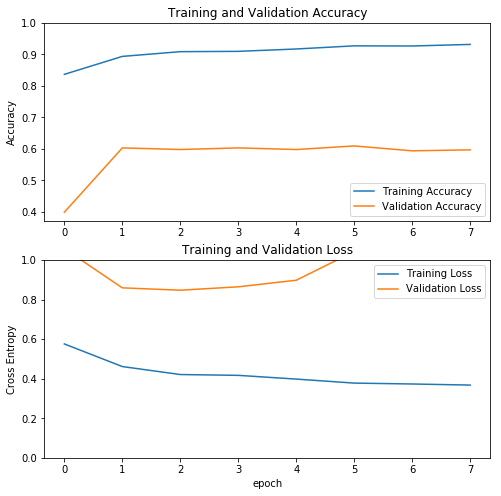

In [38]:
# check learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3.2 Fine tuning (i.e. unfreeze based model and set set bottom layers to be un-trainable)

In [39]:
x = AveragePooling2D((7, 7), name='avg_pool')(conv_base_model.layers[-1].output)
x = Flatten()(x)
x = Dense(512, activation='relu', name='dim_proj')(x)
x = Dense(512, activation='relu', name='dim_proj2')(x) # test
#x = Lambda(lambda x: l2_normalize(x, 1))(x)
o = Dense(1,activation='sigmoid', name = 'prediction_layer')(x)

new_model = Model(inputs=conv_base_model.layers[0].input, outputs=[o])

In [40]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [41]:
new_model.trainable = True

In [ ]:
# new_model.summary()

In [42]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(new_model.layers))

Number of layers in the base model:  178


In [43]:
# Fine tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [44]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [45]:
base_learning_rate = 0.0001
opt = Adam()
# opt = RMSprop(lr=base_learning_rate)

new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [46]:
history = new_model.fit_generator(train_generator,
                  steps_per_epoch= train_len // batch_size,
                  #shuffle=True,
                  epochs=10,
                  validation_data=test_generator,
                  validation_steps= test_len // batch_size,
                  callbacks=[early_stopping]
                           )

Epoch 1/10
125/125 [==============================] - 59s 468ms/step - loss: 0.4790 - acc: 0.9150 - val_loss: 1.5227 - val_acc: 0.5971
Epoch 2/10
125/125 [==============================] - 48s 385ms/step - loss: 0.3321 - acc: 0.9597 - val_loss: 2.3751 - val_acc: 0.6012
Epoch 3/10
125/125 [==============================] - 47s 380ms/step - loss: 0.2863 - acc: 0.9732 - val_loss: 6.5210 - val_acc: 0.6043
Epoch 4/10
125/125 [==============================] - 48s 384ms/step - loss: 0.2783 - acc: 0.9778 - val_loss: 1.9515 - val_acc: 0.6008
Epoch 5/10
125/125 [==============================] - 48s 386ms/step - loss: 0.2559 - acc: 0.9835 - val_loss: 2.8362 - val_acc: 0.5992
Epoch 6/10
125/125 [==============================] - 48s 385ms/step - loss: 0.2413 - acc: 0.9898 - val_loss: 2.5906 - val_acc: 0.6085
Epoch 00006: early stopping


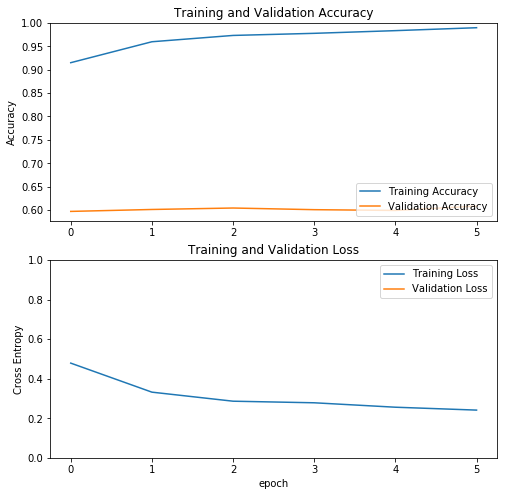

In [48]:
# check learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()